# GeoPython 2022 - Introduction to `dask-geopandas`

## Setup

```
- geopandas
- dask-geopandas
- pyogrio
- pyarrow
- python-graphviz
- esda
- extension??
```

## GeoPandas refresh
- Extending pandas with geometry support
- One or more geometry columns

In [1]:
import geopandas

In [2]:
path = geopandas.datasets.get_path("naturalearth_lowres")
path

'/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp'

In [3]:
world = geopandas.read_file(path)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [4]:
world['convex_hull'] = world.convex_hull

# This is equal to the code above as GeoPandas exposes geometry methods of the active geometry column to the GeoDataFrame level
# world['convex_hull'] = world.geometry.convex_hull  

In [5]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...","POLYGON ((177.93266 -18.28799, -180.00000 -16...."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...","POLYGON ((36.51408 -11.72094, 34.55999 -11.520..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...","POLYGON ((-17.06342 20.99975, -17.02043 21.422..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...","POLYGON ((-82.69009 41.67511, -124.01289 48.37..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...","POLYGON ((-155.68817 18.91619, -155.93665 19.0..."


<AxesSubplot:>

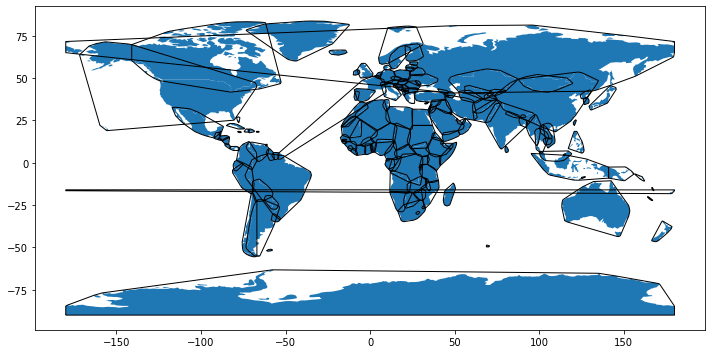

In [6]:
ax = world.plot(figsize=(12, 12))
world.convex_hull.plot(ax=ax, facecolor='none', edgecolor='black')

### GeometryArray and Shapely 2.0/PyGEOS

In [7]:
geopandas.options.use_pygeos = False

df = geopandas.read_file(path)  # TODO: read something bigger
%timeit hull = df.convex_hull

3.04 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
geopandas.options.use_pygeos = True

df = geopandas.read_file(path)  # TODO: read something bigger
%timeit hull = df.convex_hull

1.9 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### IO with Fiona and Pyogrio

In [9]:
# %%timeit
# df = geopandas.read_file(path, engine="fiona")

In [10]:
# %%timeit
# df = geopandas.read_file(path, engine="pyogrio")

## What is Dask
- parallel and distributed computation
- low-level
- high-level
    - array, bag, dataframe
- client, cluster

In [7]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

### dask.bag

In [12]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)
b

dask.bag<from_sequence, npartitions=2>

In [13]:
b.compute()

[1, 2, 3, 4, 5, 6, 2, 1]

### dask.array

In [14]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [15]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

In [16]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [17]:
a.mean().compute()

49999.5

### dask.dataframe
- many pandas DataFrames as _partitions_
- concept of delayed computation
    - task graph
    - show some mean, groupby
- inter-worker communication

In [18]:
# TODO - get something from dask docs

## Dask-GeoPandas 
- follows the same model. But *spatial is special*.
- many geopandas GeoDataFrames as _partitions_

In [8]:
import dask_geopandas

## Create dask GeoDataFrame
- from geopandas
    - npartitions
- read_file with pyogrio
- read GeoParquet
- from dask.dataframe with XY or WKT

In [9]:
world_ddf = dask_geopandas.from_geopandas(world, npartitions=4)
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
npartitions=4,,,,,,,
0,int64,object,object,object,float64,geometry,geometry
45,...,...,...,...,...,...,...
90,...,...,...,...,...,...,...
135,...,...,...,...,...,...,...
176,...,...,...,...,...,...,...


In [10]:
world_ddf = dask_geopandas.read_file(path, npartitions=4)
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
npartitions=4,,,,,,
0,int64,object,object,object,float64,geometry
45,...,...,...,...,...,...
90,...,...,...,...,...,...
135,...,...,...,...,...,...
176,...,...,...,...,...,...


In [22]:
# TODO: read some CSV with XY

### Partitioned IO
- GeoParquet

In [23]:
world_ddf.to_parquet("world/")

/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask/dataframe/io/parquet/core.py:154: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  return self.engine.write_partition(
/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask/dataframe/io/parquet/core.py:154: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github

In [24]:
world_ddf = dask_geopandas.read_parquet("world/")
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
npartitions=4,,,,,,
,int64,object,object,object,float64,geometry
,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


## Embarrassingly parallel computation
- area
- convex_hull

/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask_geopandas/core.py:95: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  meta = getattr(self._meta, attr)


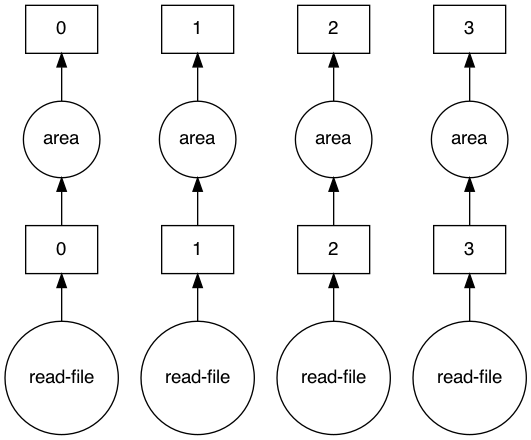

In [11]:
area = world_ddf.area
area.visualize()

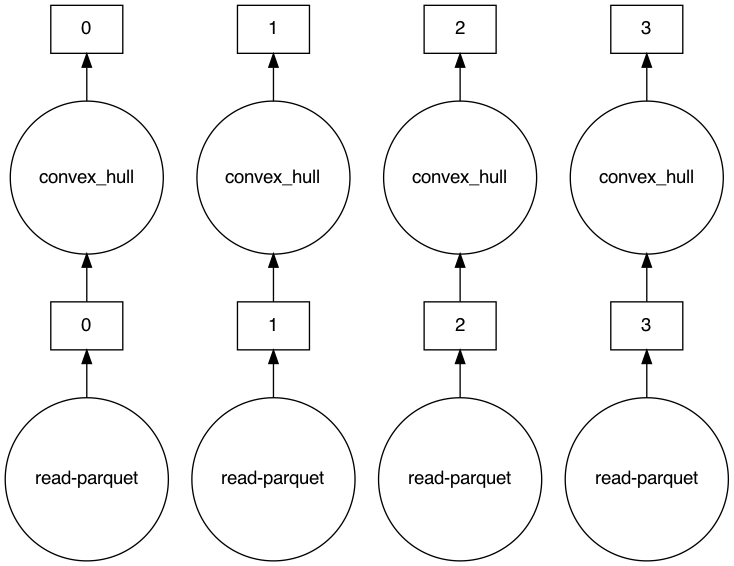

In [26]:
convex_hull = world_ddf.convex_hull
convex_hull.visualize()

/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask_geopandas/core.py:95: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  meta = getattr(self._meta, attr)


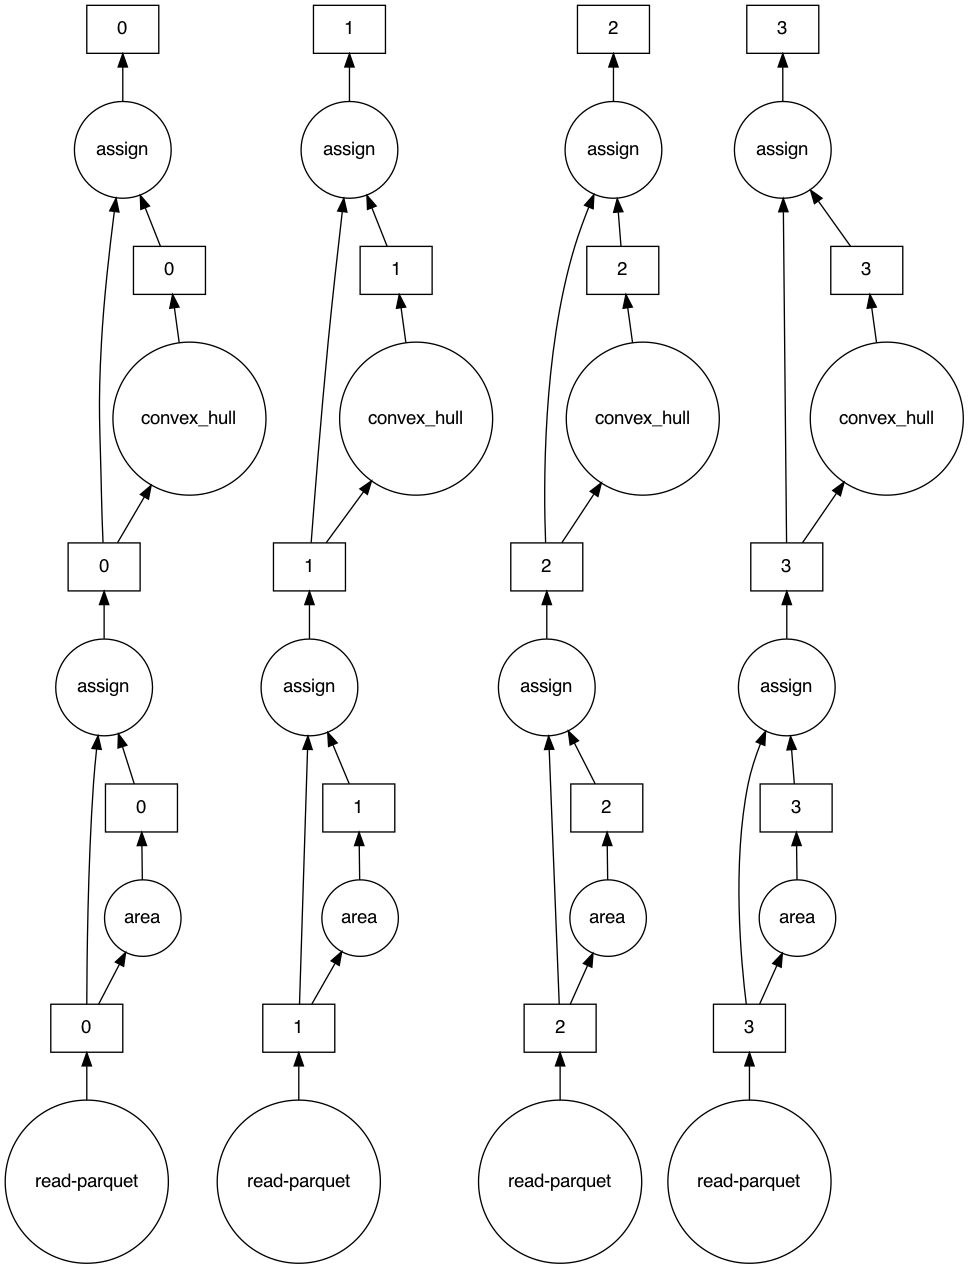

In [27]:
world_ddf['area'] = world_ddf.area
world_ddf['convex_hull'] = world_ddf.convex_hull
world_ddf.visualize()

## Spatial join
- include comparison of default and spatially shuffled df
- GADM join with airports?

In [12]:
airports = pd.read_csv("data/airports.csv")
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [13]:
airports = geopandas.GeoDataFrame(airports,
                          geometry=geopandas.GeoSeries.from_xy(
                              airports["longitude_deg"],
                              airports["latitude_deg"],
                              crs=4326
                              )
                          )

airports_ddf = dask_geopandas.from_geopandas(
    airports,
    npartitions=12
)

In [30]:
world_ddf = dask_geopandas.read_parquet("world/")  # TODO get better world with more polygons

joined = airports_ddf.sjoin(world_ddf, predicate="within")

In [31]:
joined.npartitions

48

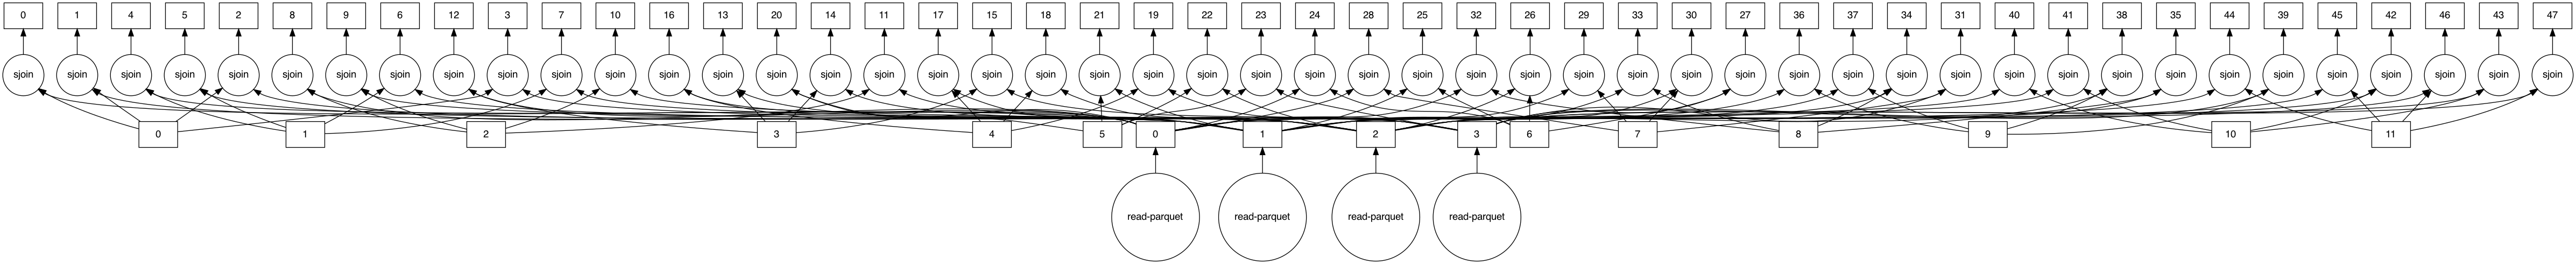

In [32]:
joined.visualize()

## Spatial partitioning
- default
- spatial shuffle
    - explain space filling curve

In [33]:
airports_ddf.calculate_spatial_partitions()

In [34]:
airports_ddf.spatial_partitions

0     POLYGON ((169.85200 11.22200, -155.97835 19.83...
1     POLYGON ((-1.00000 -89.98944, -41.03330 -77.65...
2     POLYGON ((106.84825 -78.46614, -67.75550 -54.6...
3     POLYGON ((-25.51644 -75.56741, -71.56667 -74.8...
4     POLYGON ((-36.50950 -54.28240, -155.57840 19.1...
5     POLYGON ((139.27850 -24.33880, -157.19466 1.76...
6     POLYGON ((146.39617 -41.23519, -70.64390 -38.0...
7     POLYGON ((0.00000 -90.00000, -176.20348 -44.29...
8     POLYGON ((-81.39478 -80.31420, -83.32083 -79.7...
9     POLYGON ((70.22033 -49.35033, -56.16673 -34.86...
10    POLYGON ((-155.67730 18.91630, -159.74431 21.9...
11    POLYGON ((111.52361 -66.69083, -171.43511 -14....
dtype: geometry

In [35]:
airports_ddf.spatial_partitions.explore()

In [18]:
airports_ddf = airports_ddf.spatial_shuffle()

In [37]:
airports_ddf.spatial_partitions.explore()

In [38]:
world_ddf.spatial_partitions

0    POLYGON ((180.00000 -55.61183, 180.00000 83.64...
1    POLYGON ((167.84488 -29.04546, 167.84488 37.38...
2    POLYGON ((167.12001 -22.39998, 167.12001 69.10...
3    POLYGON ((180.00000 -90.00000, 180.00000 70.16...
dtype: geometry

In [39]:
world_ddf.spatial_partitions.explore()

In [40]:
world_ddf = world_ddf.spatial_shuffle()
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
npartitions=4,,,,,,
375036506,int64,object,object,object,float64,geometry
2071195797,...,...,...,...,...,...
2306225857,...,...,...,...,...,...
2446126456,...,...,...,...,...,...
3764119180,...,...,...,...,...,...


In [41]:
world_ddf.spatial_partitions.explore()

In [42]:
joined = airports_ddf.sjoin(world_ddf, predicate="within")

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_39871/1671005557.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  joined = airports_ddf.sjoin(world_ddf, predicate="within")


In [43]:
joined.npartitions

25

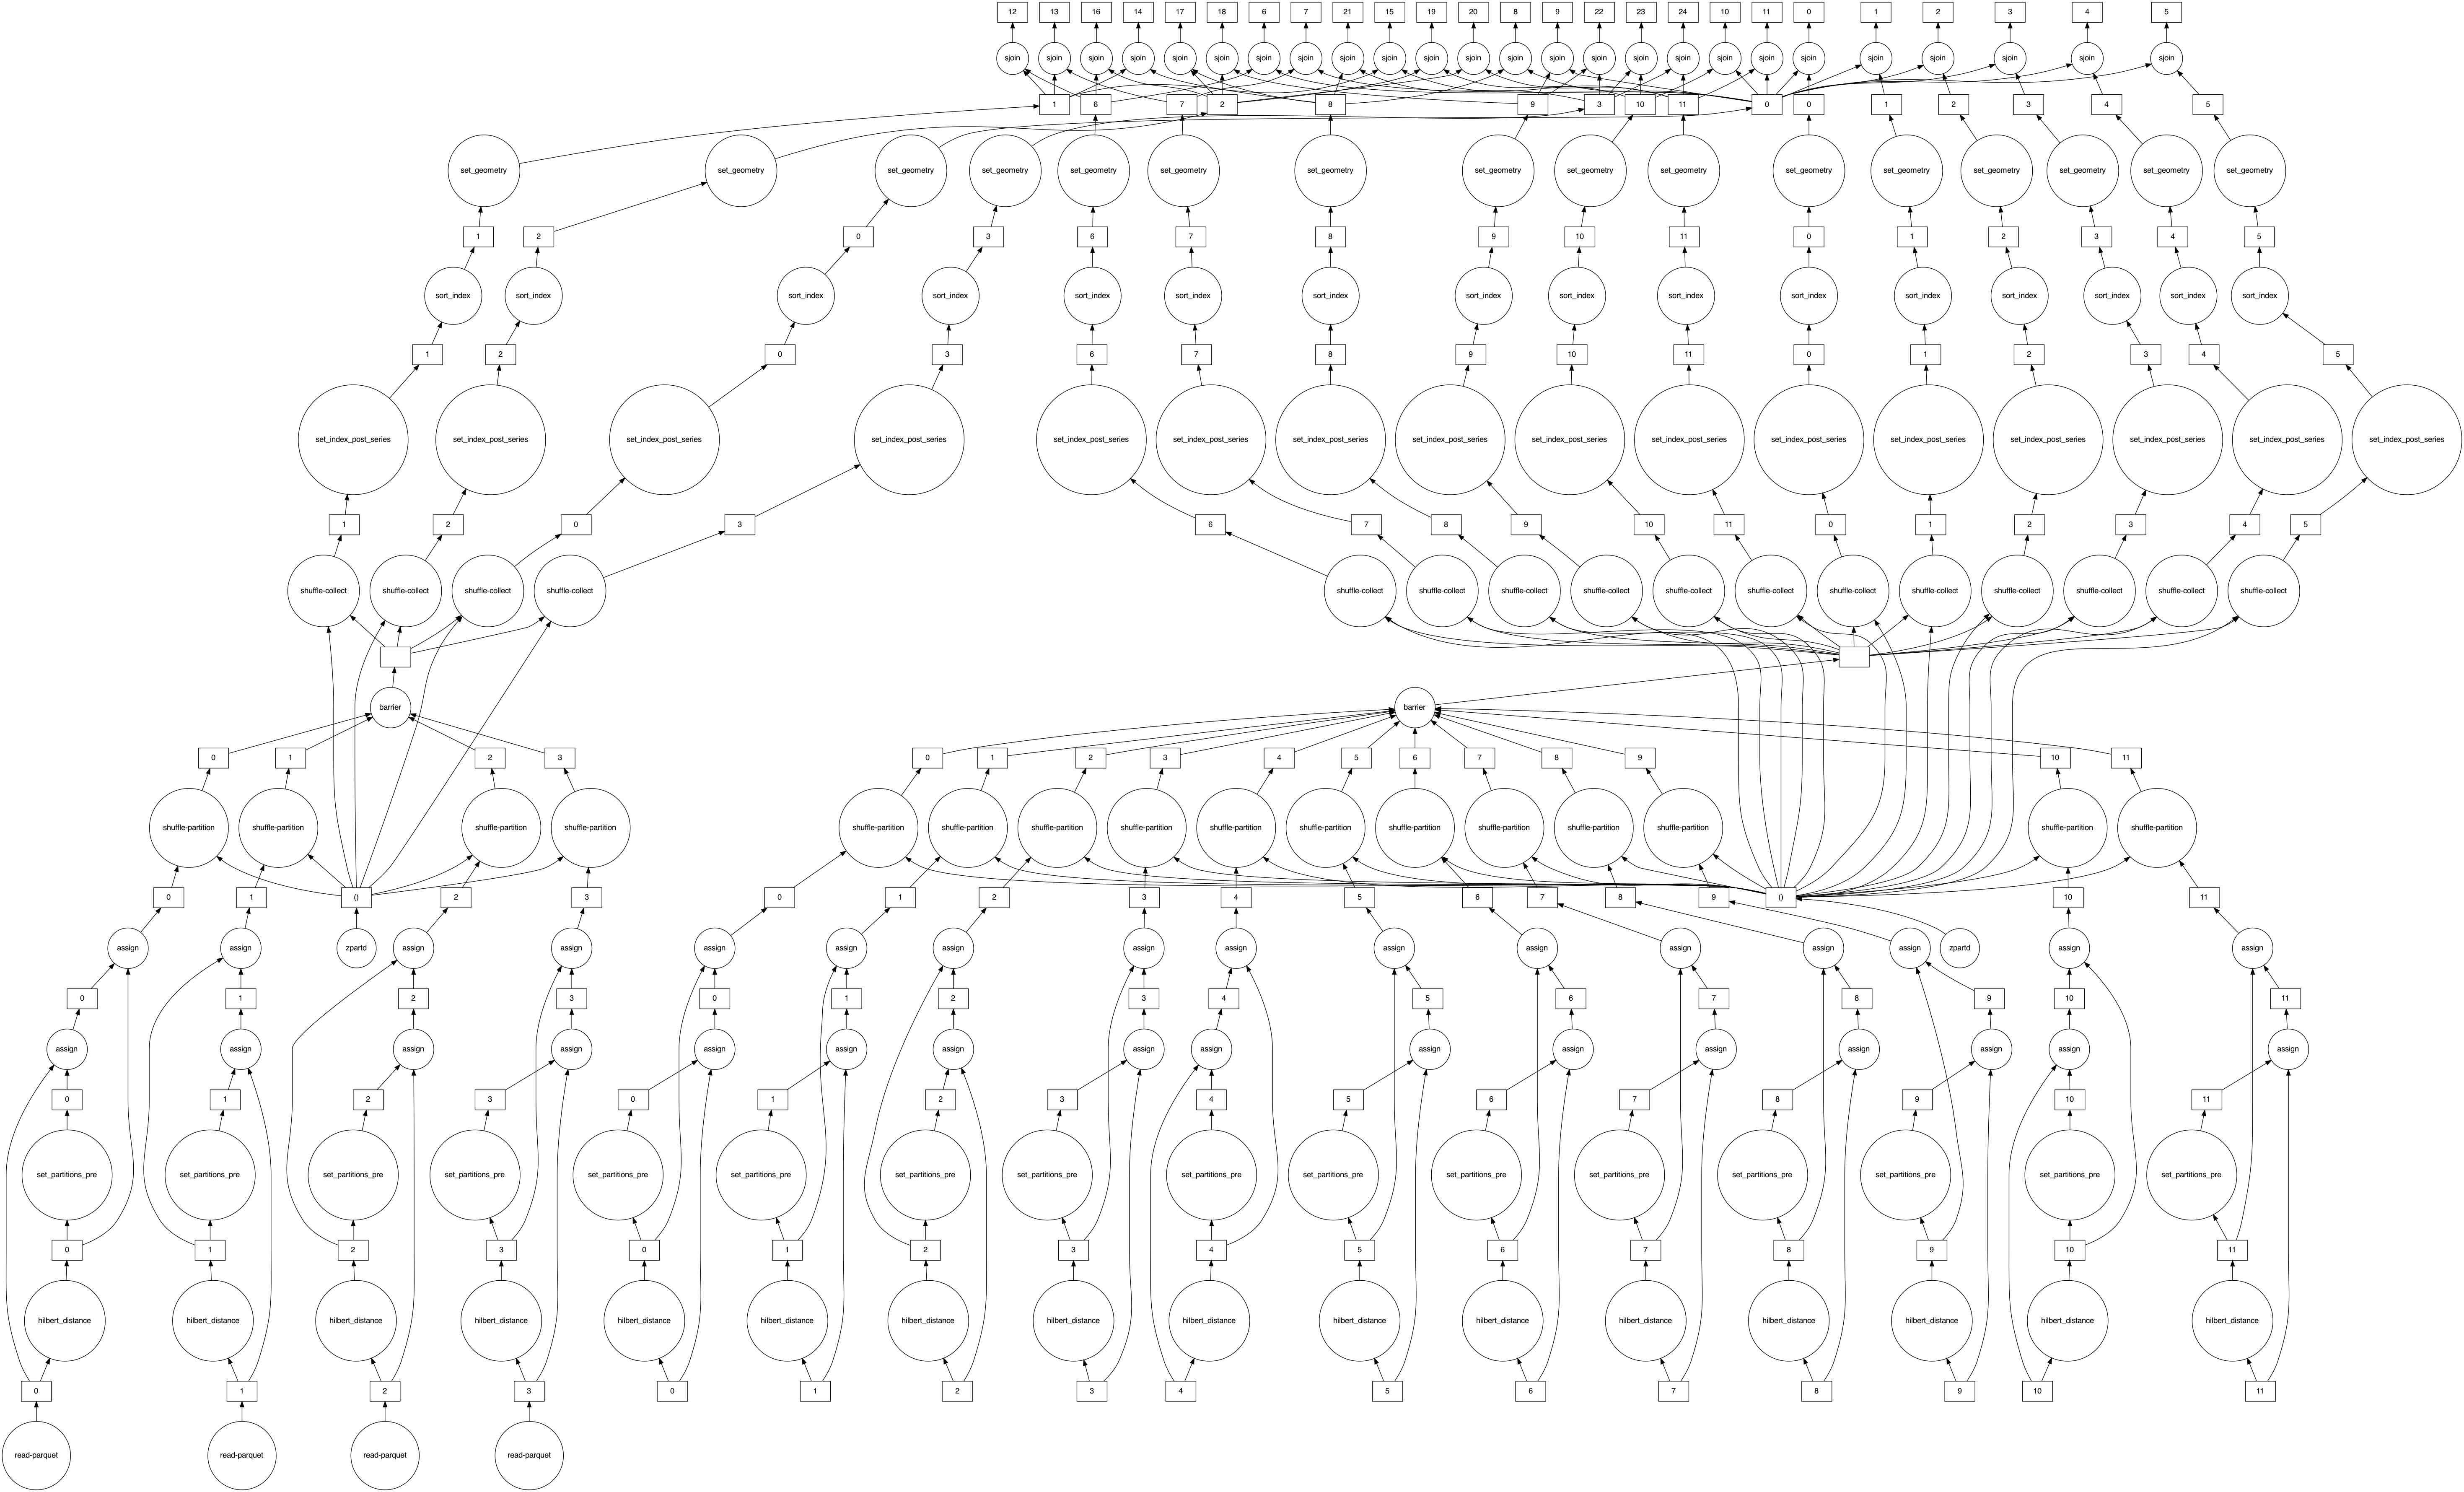

In [44]:
joined.visualize()

In [45]:
%%time
joined.compute()

CPU times: user 824 ms, sys: 253 ms, total: 1.08 s
Wall time: 935 ms


,id,ident,type,name_left,latitude_deg,longitude_deg,elevation_ft,continent_left,iso_country,iso_region,...,home_link,wikipedia_link,keywords,geometry,index_right,pop_est,continent_right,name_right,iso_a3,gdp_md_est
hilbert_distance,,,,,,,,,,,,,,,,,,,,,
281194929,32268,SCPZ,small_airport,Patriot Hills Airport,-80.314200,-81.394780,2900.0,AN,AQ,AQ-U-A,...,NaN,NaN,NaN,POINT (-81.39478 -80.31420),375036506,4050,Antarctica,Antarctica,ATA,810.0
281397523,45059,SCGC,small_airport,Union Glacier Blue-Ice Runway,-79.777778,-83.320833,2461.0,AN,AQ,AQ-U-A,...,NaN,https://en.wikipedia.org/wiki/Union_Glacier_Bl...,NaN,POINT (-83.32083 -79.77778),375036506,4050,Antarctica,Antarctica,ATA,810.0
298653174,324046,EGAT,small_airport,Sky Blu Airstrip,-74.849722,-71.566666,4740.0,AN,AQ,AQ-U-A,...,https://www.bas.ac.uk/polar-operations/sites-a...,https://en.wikipedia.org/wiki/Sky_Blu,NaN,POINT (-71.56667 -74.84972),375036506,4050,Antarctica,Antarctica,ATA,810.0
357907098,336960,AQ-0005,medium_airport,Jack F. Paulus Skiway,-89.989444,-1.000000,9300.0,AN,AQ,AQ-U-A,...,NaN,https://en.wikipedia.org/wiki/Jack_F._Paulus_S...,NaN,POINT (-1.00000 -89.98944),375036506,4050,Antarctica,Antarctica,ATA,810.0
495162282,308226,SCBO,small_airport,General Bernardo O'Higgins Base Skyway,-63.344000,-57.842000,900.0,AN,AQ,AQ-U-A,...,NaN,NaN,NaN,POINT (-57.84200 -63.34400),375036506,4050,Antarctica,Antarctica,ATA,810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639120321,30135,FDMH,small_airport,Mhlume Airport,-26.024200,31.809999,926.0,AF,SZ,SZ-LU,...,NaN,NaN,NaN,POINT (31.81000 -26.02420),3639074371,1467152,Africa,eSwatini,SWZ,11060.0
3639138881,308033,FDSK,large_airport,King Mswati III International Airport,-26.358611,31.716944,1092.0,AF,SZ,SZ-LU,...,http://www.eswacaa.co.sz/airports/kingmswatiIII/,https://en.wikipedia.org/wiki/King_Mswati_III_...,Sikhuphe International Airport,POINT (31.71694 -26.35861),3639074371,1467152,Africa,eSwatini,SWZ,11060.0
3639140943,31109,FDST,small_airport,Siteki Airport,-26.471957,31.942567,2220.0,AF,SZ,SZ-LU,...,NaN,NaN,NaN,POINT (31.94257 -26.47196),3639074371,1467152,Africa,eSwatini,SWZ,11060.0


In [15]:
import pyogrio

gadm = pyogrio.read_dataframe('data/gadm404.gpkg')

In [16]:
%%time
r = airports.sjoin(gadm, predicate="within")
r.head()

CPU times: user 3.12 s, sys: 1.06 s, total: 4.18 s
Wall time: 4.93 s


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,...,GID_5,NAME_5,CC_5,TYPE_5,ENGTYPE_5,GOVERNEDBY,SOVEREIGN,DISPUTEDBY,REGION,VARREGION
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,...,,,,,,,United States,,,
610,7050,09PN,heliport,Hundley Residence Heliport,40.562000,-75.142700,480.0,NaN,US,US-PA,...,,,,,,,United States,,,
1061,7476,0PA0,small_airport,Philadelphia Gliderport,40.331227,-75.248125,670.0,NaN,US,US-PA,...,,,,,,,United States,,,
1070,7485,0PA9,heliport,Carson Heliport,40.333401,-75.216301,415.0,NaN,US,US-PA,...,,,,,,,United States,,,
1090,7505,0PS9,heliport,Jefferson Health Bucks County Campus Heliport,40.182734,-74.868028,141.0,NaN,US,US-PA,...,,,,,,,United States,,,


In [17]:
gadm_ddf = dask_geopandas.from_geopandas(gadm, npartitions=64)
joined = airports_ddf.sjoin(gadm_ddf, predicate="within")
joined.npartitions

768

In [19]:
gadm_ddf = gadm_ddf.spatial_shuffle()
joined = airports_ddf.sjoin(gadm_ddf, predicate="within")
joined.npartitions

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_86064/591206714.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  joined = airports_ddf.sjoin(gadm_ddf, predicate="within")


154

## Aggregations with dissolve

In [47]:
world_ddf = dask_geopandas.read_parquet("world/")  # TODO get better world with more polygons
continents = world_ddf.dissolve('continent', split_out=6)
continents

,pop_est,name,iso_a3,gdp_md_est,geometry
npartitions=6,,,,,
,int64,object,object,float64,geometry
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


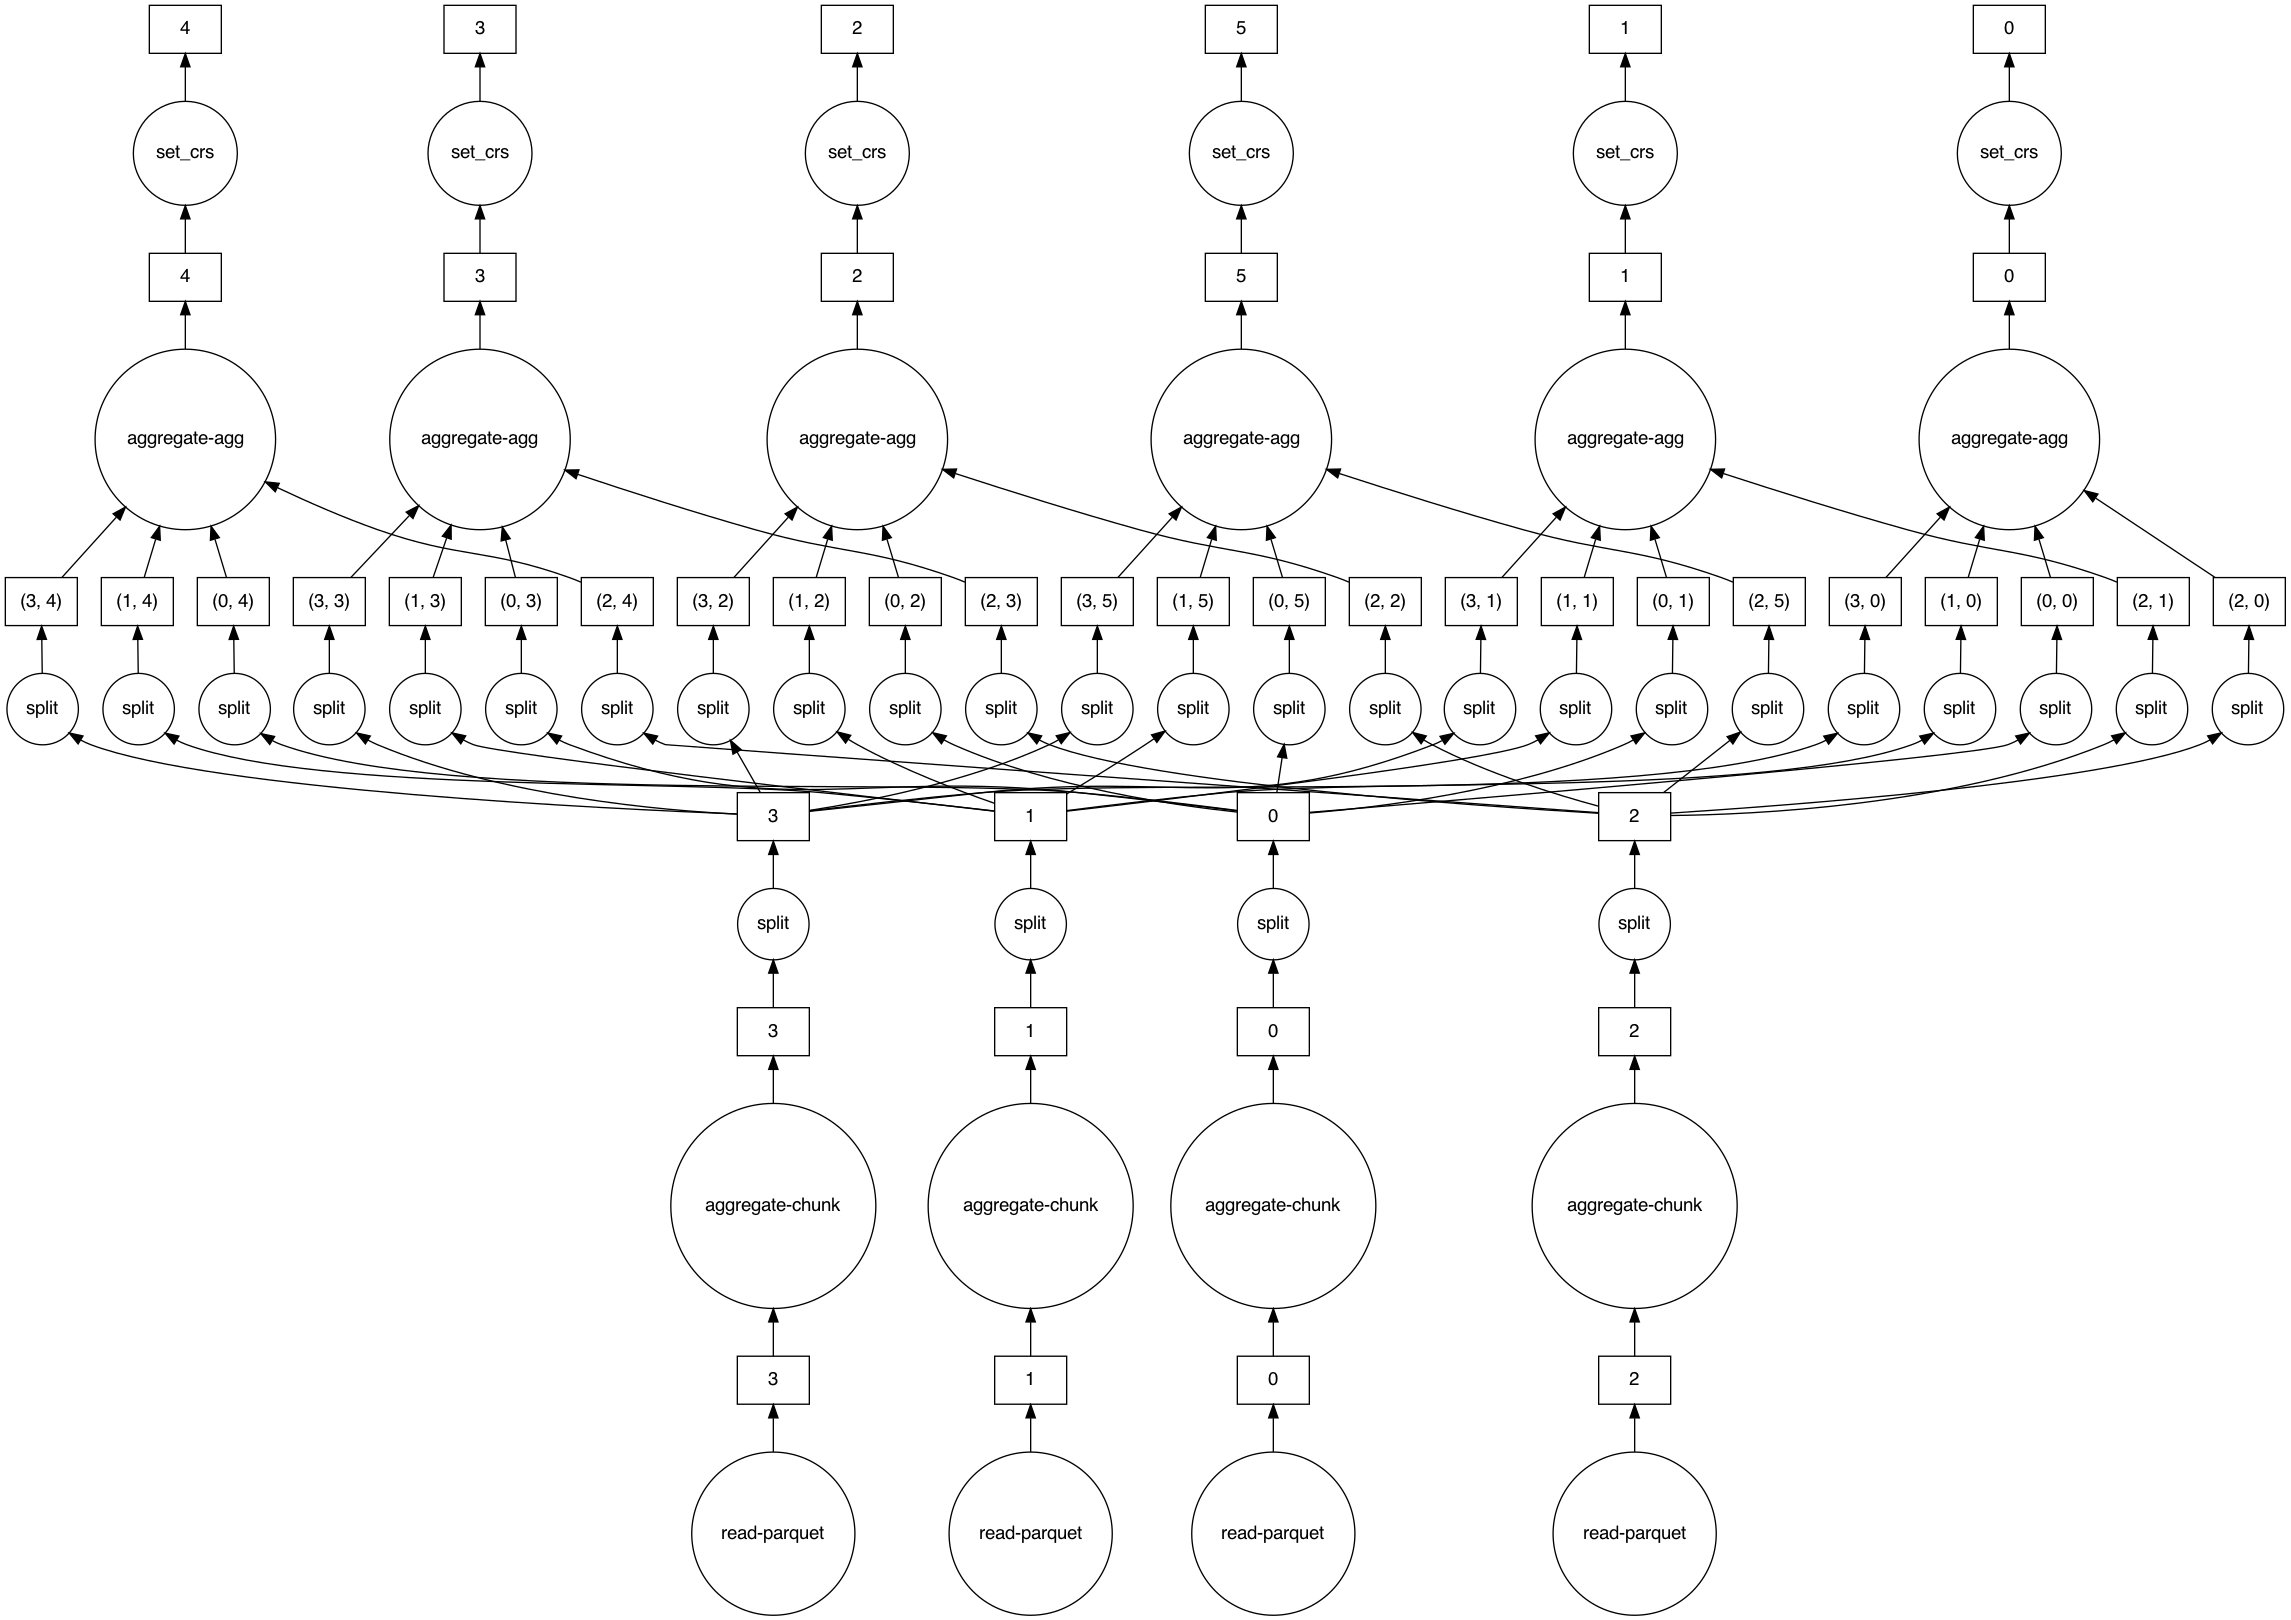

In [48]:
continents.visualize()

## Custom functions
- map_partitions
    - ESDA shape
- custom dissolve as an illustration (from the user guide)

In [49]:
from esda.shape import shape_index

In [50]:
world['shape_idx'] = shape_index(world)

In [51]:
world.explore('shape_idx')

In [52]:
world_ddf = dask_geopandas.read_parquet("world/")  # TODO get better world with more polygons
shape_idx = world_ddf.map_partitions(shape_index)

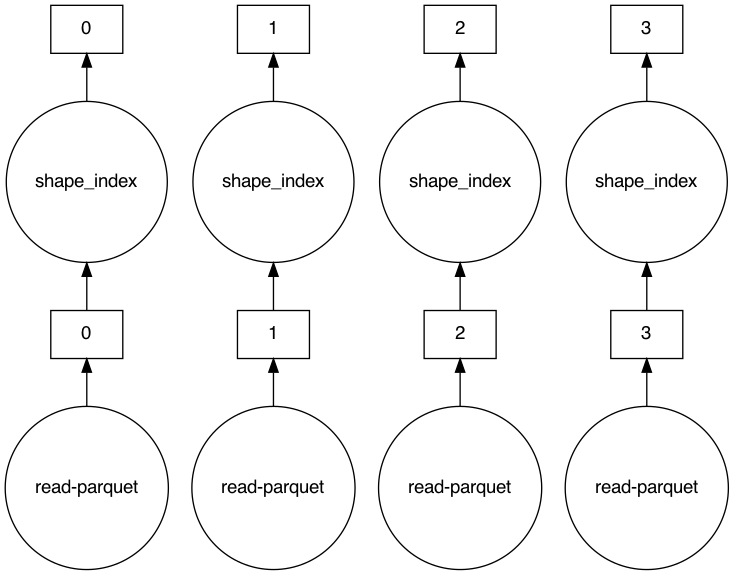

In [53]:
shape_idx.visualize()

In [54]:
r = shape_idx.compute()

## Running dask-geopandas on a cluster
- some embarrassingly parallel things
- spatial join?

## Limits and caveats
- topology and cross-partition operations
- limited plotting support

## Exercises